This time we use PM25 data

In [31]:
import pandas as pd
import numpy as np
import xarray as xr
from read_data import read_data


df_merged, df_avg = read_data("PM25_24g")

data_wal = df_merged["DsWalbrzWyso"]
data_wal = data_wal[data_wal.index.year > 2014]

data_wal = data_wal.to_xarray()

#let's save the data to netcdf file
data_wal.to_netcdf('wal_PM25_24.nc')

Wczytywanie: .\2002\2002_PM25_24g.xlsx
Wczytywanie: .\2003\2003_PM25_24g.xlsx
Wczytywanie: .\2004\2004_PM25_24g.xlsx
Wczytywanie: .\2005\2005_PM25_24g.xlsx
Wczytywanie: .\2006\2006_PM25_24g.xlsx
Wczytywanie: .\2007\2007_PM25_24g.xlsx
Wczytywanie: .\2008\2008_PM25_24g.xlsx
Wczytywanie: .\2009\2009_PM25_24g.xlsx
Wczytywanie: .\2010\2010_PM25_24g.xlsx
Wczytywanie: .\2011\2011_PM25_24g.xlsx
Wczytywanie: .\2012\2012_PM25_24g.xlsx
Wczytywanie: .\2013\2013_PM25_24g.xlsx
Wczytywanie: .\2014\2014_PM25_24g.xlsx
Wczytywanie: .\2015\2015_PM25_24g.xlsx
Wczytywanie: .\2016\2016_PM25_24g.xlsx
Wczytywanie: .\2017\2017_PM25_24g.xlsx
Wczytywanie: .\2018\2018_PM25_24g.xlsx
Wczytywanie: .\2019\2019_PM25_24g.xlsx
Wczytywanie: .\2020\2020_PM25_24g.xlsx
Wczytywanie: .\2021\2021_PM25_24g.xlsx
Wczytywanie: .\2022\2022_PM25_24g.xlsx
Wczytywanie: .\2023\2023_PM25_24g.xlsx
            MpKrakBulwar  MpKrakowWIOSPrad6115  LdLodzLegion  \
Data                                                           
2002-01-01    

d:\MOJE\ERA5+MLwalbrzych\read_data.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_merged = df_renamed.groupby(axis=1, level=0).mean(numeric_only=True)


In [32]:
import xarray as xr
import pandas as pd
import numpy as np

wal_pm = xr.open_dataset('wal_PM25_24.nc').to_dataframe()
wal_weather = xr.open_dataset("wal_weather.nc").to_dataframe()

wal_pm

,DsWalbrzWyso
Data,
2015-01-01,30.4
2015-01-02,12.2
2015-01-03,14.0
2015-01-04,7.4
2015-01-05,7.0
...,...
2023-12-27,5.2
2023-12-28,11.3
2023-12-29,4.7


now we prepare the data for machine learning

In [33]:
wal_pm.rename(columns={'DsWalbrzWyso': 'pm10'}, inplace=True)
wal_pm = wal_pm[['pm10']]  # zostawiamy tylko pm10
wal_pm.index.name = 'date'

# Przygotowanie wal_weather
wal_weather = wal_weather.reset_index()
wal_weather['date'] = pd.to_datetime(wal_weather['date'])
wal_weather = wal_weather.set_index('date')
wal_weather = wal_weather.drop(wal_weather.index[0])
wal_weather = wal_weather.drop(wal_weather.index[-1])


# Połączenie danych (dopasowane po indeksie)
wal_pm = pd.concat([wal_pm, wal_weather], axis=1)
wal_pm = wal_pm.drop(columns = ['cape_mean', 'cape_max', 'cape_min'], axis = 1)
wal_pm

wal_pm['month'] = wal_pm.index.month
wal_pm['weekday'] = wal_pm.index.weekday
wal_pm['yearday'] = wal_pm.index.dayofyear


# Lag features (co było w przeszłości)
for lag in [1, 2, 3]:
    wal_pm[f'temperature_2m_min_lag{lag}'] = wal_pm['temperature_2m_min'].shift(lag)
    wal_pm[f'precipitation_sum_lag{lag}'] = wal_pm['precipitation_sum'].shift(lag)
    wal_pm[f'boundary_layer_height_lag{lag}'] = wal_pm['boundary_layer_height'].shift(lag)
    wal_pm[f'wind_speed_10m_min_lag{lag}'] = wal_pm['wind_speed_10m_min'].shift(lag)
    wal_pm[f'wind_direction_10m_dominant_lag{lag}'] = wal_pm['wind_direction_10m_dominant'].shift(lag)

wal_pm = wal_pm.dropna()
wal_pm

,pm10,temperature_2m_mean,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,...,temperature_2m_min_lag2,precipitation_sum_lag2,boundary_layer_height_lag2,wind_speed_10m_min_lag2,wind_direction_10m_dominant_lag2,temperature_2m_min_lag3,precipitation_sum_lag3,boundary_layer_height_lag3,wind_speed_10m_min_lag3,wind_direction_10m_dominant_lag3
date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,7.0,-0.847833,0.460500,-2.489500,8.400000,0.000000,5.88,6.881860,314.149841,0.88,...,-0.489500,0.0,918.750000,4.477723,255.062943,0.4105,0.600000,718.333313,4.465423,241.579300
2015-01-06,55.5,-5.914501,-2.839500,-9.939500,0.000000,0.000000,0.00,3.275668,193.172546,3.25,...,-1.639500,1.9,1217.916626,5.345091,309.481964,-0.4895,0.000000,918.750000,4.477723,255.062943
2015-01-07,25.0,-4.060334,-1.339500,-8.789499,1.000000,0.000000,0.98,5.594640,209.744781,2.43,...,-2.489500,8.4,765.625000,3.080584,314.149841,-1.6395,1.900000,1217.916626,5.345091,309.481964
2015-01-08,17.3,0.093833,3.710500,-2.889500,5.500000,5.400000,0.14,7.793587,213.016693,2.19,...,-9.939500,0.0,111.666664,0.223607,193.172546,-2.4895,8.400000,765.625000,3.080584,314.149841
2015-01-09,7.0,3.650084,5.260500,1.360500,7.599999,7.599999,0.00,10.171037,263.017731,2.96,...,-8.789499,1.0,230.000000,2.690725,209.744781,-9.9395,0.000000,111.666664,0.223607,193.172546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,5.2,3.027166,4.510500,0.910500,0.000000,0.000000,0.00,10.208329,233.513443,4.28,...,7.410500,2.9,1116.666626,3.981206,242.727905,-0.0895,12.400001,701.250000,2.332381,233.726822
2023-12-28,11.3,4.800083,6.360500,3.260500,0.000000,0.000000,0.00,10.430724,214.158920,3.15,...,4.360500,0.2,1041.250000,5.292448,242.176819,7.4105,2.900000,1116.666626,3.981206,242.727905
2023-12-29,4.7,7.139667,8.410501,5.160500,0.000000,0.000000,0.00,9.899495,223.687241,3.39,...,0.910500,0.0,589.583313,2.624881,233.513443,4.3605,0.200000,1041.250000,5.292448,242.176819


In [34]:
X = wal_pm.drop(columns=['pm10'])
y = wal_pm['pm10']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Let's show everything at once:

RMSE: 8.68
R² score: 0.68


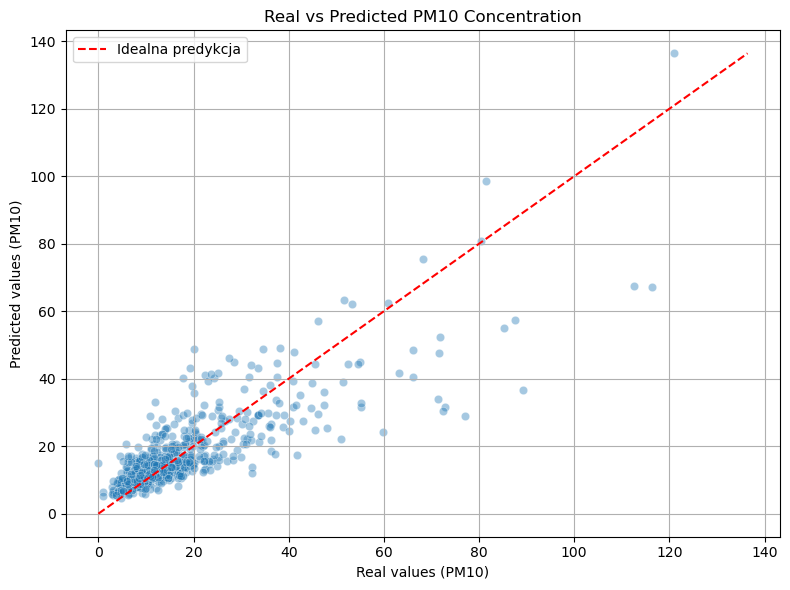

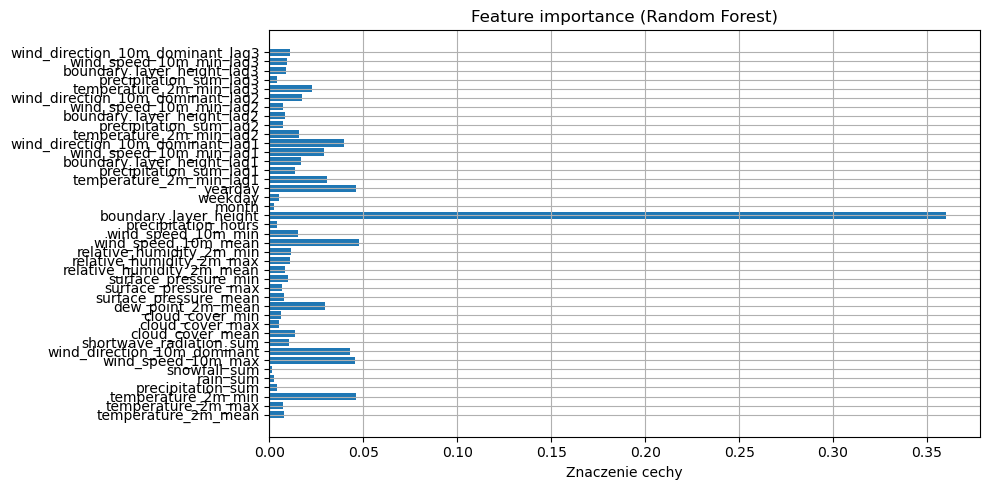

In [35]:
y_pred = model.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns

def show_model_performance(y_test, y_pred, X_train):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"R² score: {r2:.2f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)

    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idealna predykcja')

    plt.xlabel("Real values (PM10)")
    plt.ylabel("Predicted values (PM10)")
    plt.title("Real vs Predicted PM10 Concentration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    importances = model.feature_importances_
    feature_names = X_train.columns

    plt.figure(figsize=(10,5))
    plt.barh(feature_names, importances)
    plt.xlabel('Znaczenie cechy')
    plt.title('Feature importance (Random Forest)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_model_performance(y_test, y_pred, X_train)



Ok, for PM25 it is much better! We have RMSE: 8.68 and R² score: 0.68. This is really nice, because we use only weather data, not any air pollution model

Let's try to improve our model even further: using RFE functionality:

In [36]:
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
print("Wybrane cechy:", X.columns[rfe.support_])

Wybrane cechy: Index(['temperature_2m_min', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'relative_humidity_2m_min',
       'wind_speed_10m_mean', 'boundary_layer_height', 'yearday',
       'temperature_2m_min_lag1', 'wind_direction_10m_dominant_lag1',
       'temperature_2m_min_lag3'],
      dtype='object')


In [37]:
#Let's use the selected features to train a new model
selected_features = X.columns[rfe.support_]
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
selected_features

Index(['temperature_2m_min', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'relative_humidity_2m_min',
       'wind_speed_10m_mean', 'boundary_layer_height', 'yearday',
       'temperature_2m_min_lag1', 'wind_direction_10m_dominant_lag1',
       'temperature_2m_min_lag3'],
      dtype='object')

RMSE: 8.71
R² score: 0.68


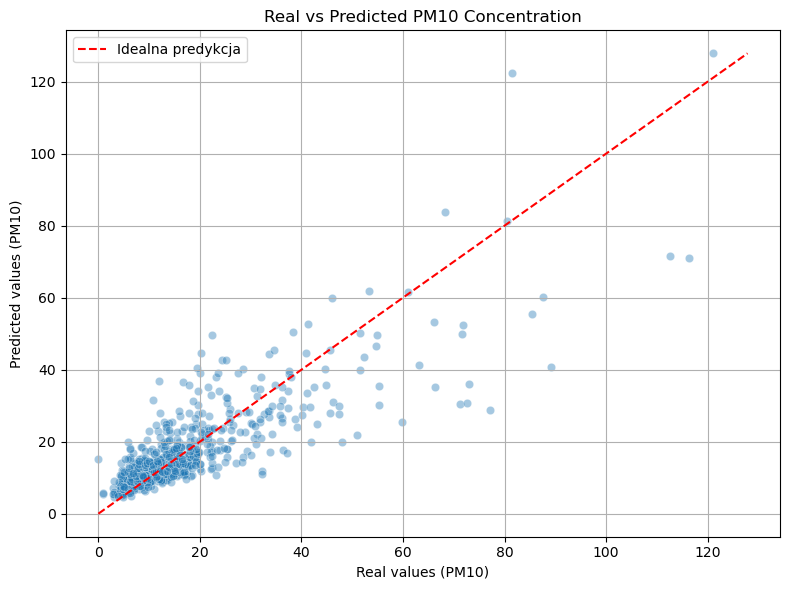

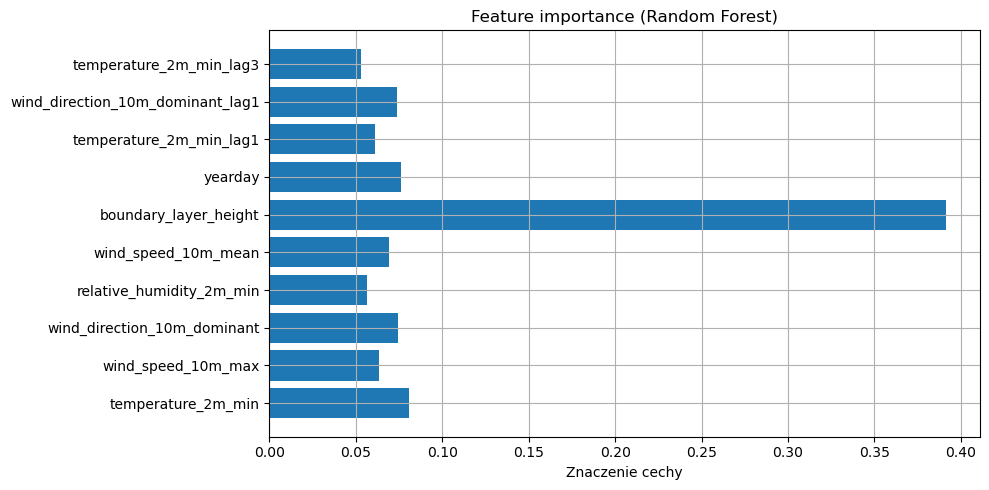

In [38]:
show_model_performance(y_test, y_pred, X_train_rfe)

The model performance is simillar, wa can try different number:

In [39]:
rfe = RFE(estimator=model, n_features_to_select=15)
rfe.fit(X_train, y_train)
print("Wybrane cechy:", X.columns[rfe.support_])

Wybrane cechy: Index(['temperature_2m_min', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'cloud_cover_mean', 'dew_point_2m_mean',
       'surface_pressure_mean', 'relative_humidity_2m_min',
       'wind_speed_10m_mean', 'boundary_layer_height', 'yearday',
       'temperature_2m_min_lag1', 'boundary_layer_height_lag1',
       'wind_speed_10m_min_lag1', 'wind_direction_10m_dominant_lag1',
       'temperature_2m_min_lag3'],
      dtype='object')


In [40]:
#Let's use the selected features to train a new model
selected_features = X.columns[rfe.support_]
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

RMSE: 8.55
R² score: 0.69


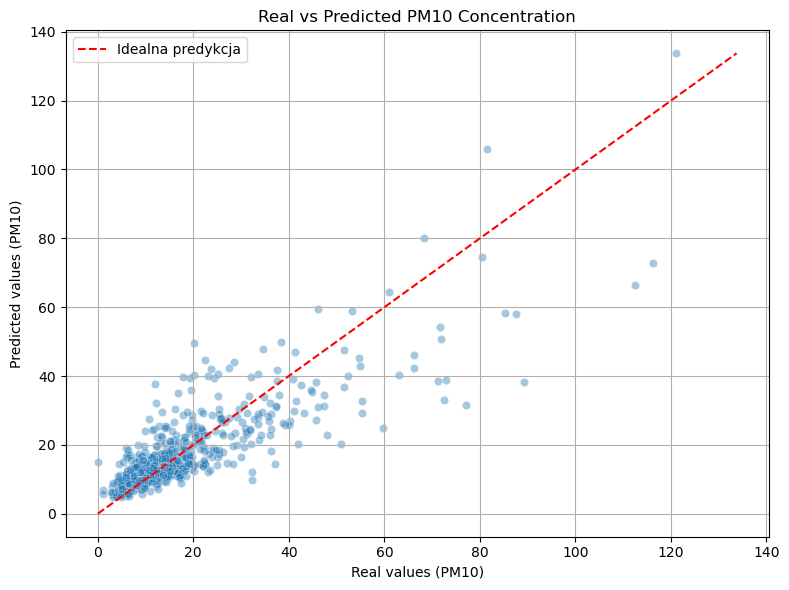

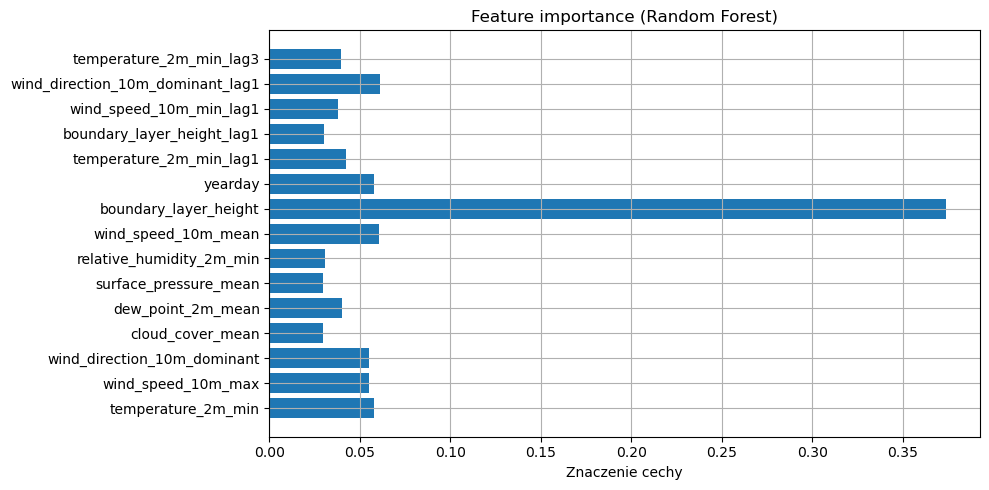

In [41]:
show_model_performance(y_test, y_pred, X_train_rfe)

Now we can also search for optimal parameters for our model

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1)
search.fit(X_train_rfe, y_train)
print("Najlepsze parametry:", search.best_params_)

Najlepsze parametry: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 147}


In [43]:
model = RandomForestRegressor(n_estimators=147, random_state=42, max_depth=30, min_samples_split=10, min_samples_leaf=2)
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

RMSE: 8.68
R² score: 0.68


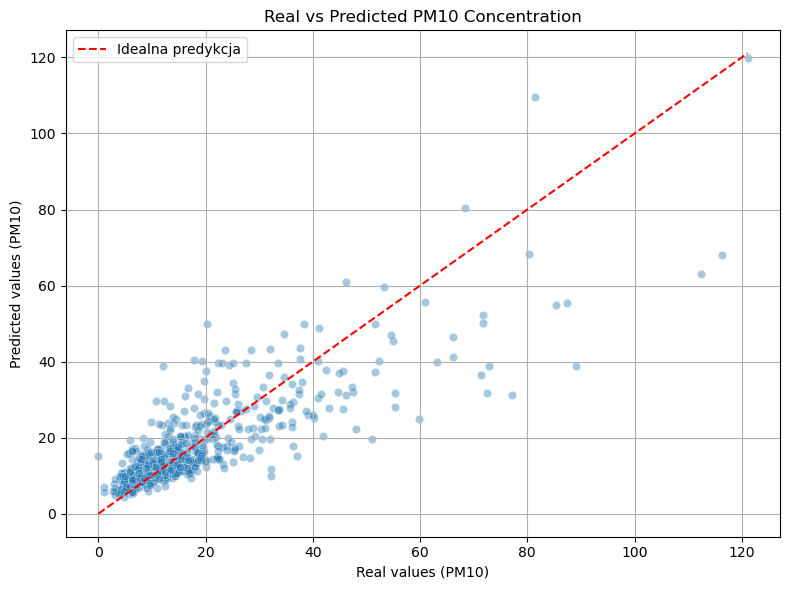

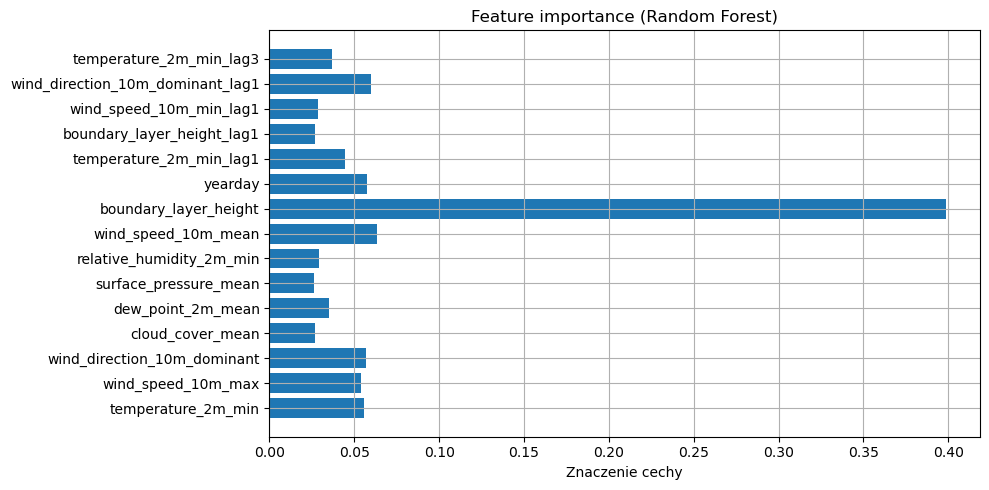

In [44]:
show_model_performance(y_test, y_pred, X_train_rfe)

Why we obtained worse RMSE and R^2 than witchout parameter fitting? We can ask chat gpt, cause why not:

# Why does RandomizedSearchCV give worse RMSE than the default RandomForest?

This is a pretty common situation 🙂  

---

## 1. The default RandomForest is already quite strong
- The default `RandomForestRegressor` (`n_estimators=100`, unlimited depth) often works very well out of the box.  
- Your `param_dist` restricts the search space — e.g., if it picks `max_depth=10`, the model may be *less complex* than the default (worse fit → higher RMSE).

---

## 2. RandomizedSearchCV optimizes for CV, not your test set
- `search.best_params_` are the parameters that performed best on **average CV-score**.  
- If your dataset is small or highly variable, the params that look good in CV might actually perform worse on the held-out test set.

---

## 3. Number of iterations (`n_iter=20`) is too small
Your parameter space is:  
- `n_estimators`: 200 values  
- `max_depth`: 4 values  
- `min_samples_split`: 3 values  
- `min_samples_leaf`: 3 values  

➡️ That’s about **7200 combinations**.  

You only sample **20** → it’s easy to miss a better set than the defaults.

---

## 4. Possible overfitting or underfitting due to parameters
Examples:  
- `min_samples_leaf=4` → trees are shallower, model underfits.  
- `max_depth=10` → cuts tree growth, model is less flexible.  

---

## ✅ What you can try

1. **Increase `n_iter`** (e.g., to 100–200).  
2. **Broaden / adjust your parameter grid** — allow `max_depth=None` more often, increase `n_estimators`.  
3. **Use `scoring="neg_root_mean_squared_error"`** explicitly in `RandomizedSearchCV` so that it optimizes for the same metric you evaluate:  

   ```python
   from sklearn.model_selection import RandomizedSearchCV
   from scipy.stats import randint
   from sklearn.ensemble import RandomForestRegressor

   param_dist = {
       'n_estimators': randint(100, 300),
       'max_depth': [None, 10, 20, 30],
       'min_samples_split': [2, 5, 10],
       'min_samples_leaf': [1, 2, 4]
   }

   model = RandomForestRegressor(random_state=42)
   search = RandomizedSearchCV(
       model,
       param_dist,
       n_iter=100,              # increase number of iterations
       cv=3,
       random_state=42,
       n_jobs=-1,
       scoring="neg_root_mean_squared_error"
   )
   search.fit(X_train_rfe, y_train)
   print("Best parameters:", search.best_params_)
